In [4]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score


In [5]:
# Загрузить данные из файлов
matches706_team_picks = pd.read_csv('table/table with features teams, heroes & kills (all team) 7.06.csv').drop(['Unnamed: 0'], axis=1)
# matches707_team_picks = pd.read_csv('table with carry or support in 7.07 to 29.12.17.csv', index_col=0)

# оставить только героев и победитлей и кол-во киллов:
matches706_heroes = matches706_team_picks.loc[:, :'Pangolier']
matches706_heroes['radiant_win'] = matches706_team_picks['radiant_win']
matches706_heroes['kills'] = matches706_team_picks['kills']
# выбросить dark Willow и Pangolier
matches706_heroes = matches706_heroes.drop(['Dark Willow', 'Pangolier'], axis=1)

#чтобы не переписывать код:
matches706_team_picks = matches706_heroes

matches706_team_picks[:2]

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Earth Spirit,Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden,Monkey King,radiant_win,kills
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,33
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,57


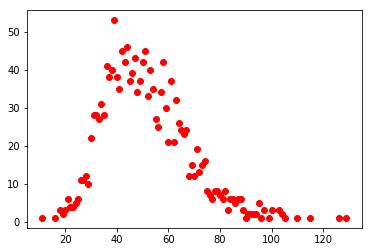

In [15]:
plt.plot(matches706_heroes['kills'].value_counts().index, matches706_heroes['kills'].value_counts(), 'ro')
plt.show()

In [3]:
# Проверка киллов на ошибки и выбросы
kill = matches706_heroes['kills']
print(kill.describe())
# Определим квартили 25 и 75 и найдем интерквартильный размах
quart25 = kill.quantile(0.25)
quart75 = kill.quantile(0.75)
iqr = quart75 - quart25
# найдем имнимальные и максимальные значения килов за пределами которых лежат выбросы 
minimum = quart25 - 1.5*iqr
maximum = quart75 + 1.5*iqr
print (minimum, maximum)
# уберем эти выбросы
a = kill[kill >= maximum]
print (a.index)
print (len(a))
# выбросить все строчки с индексами в "а"
matches706_team_picks = matches706_team_picks.drop(a.index)
matches706_team_picks['kills'].describe()


count    1599.000000
mean       51.111320
std        16.007824
min        11.000000
25%        39.000000
50%        49.000000
75%        61.000000
max       129.000000
Name: kills, dtype: float64
6.0 94.0
Int64Index([ 235,  258,  325,  351,  514,  574,  599,  676,  680,  682,  699,
             716,  721,  769,  812,  814,  916,  925, 1081, 1209, 1314, 1453,
            1459, 1558, 1582],
           dtype='int64')
25


count    1574.000000
mean       50.302414
std        14.735473
min        11.000000
25%        39.000000
50%        49.000000
75%        60.000000
max        93.000000
Name: kills, dtype: float64

In [4]:
# Проверка на то что во всех строчках есть всегда 10 героев
# a = matches706_team_picks.loc[:, :'Pangolier']
# value = []
# for i in range(len(a)):
#     arr = []
#     for val in a.loc[i, : ]:
#         if val != 0 :
#             arr.append(val)
#     value.append(arr)
# for i in value:
#     if len(i) !=10:
#         print(1)


In [22]:
# # Соединить даныне
# matches_team_picks = matches706_team_picks.append(matches707_team_picks).reset_index().drop(['index'], axis=1)

#Разделение данных без перемешивания на traning & test для каждого патча и для соединенных данных
X_706, y_706 = np.split(matches706_team_picks, [len(matches706_team_picks) - int(len(matches706_team_picks)*0.3)]) 
# X_707, y_707 = np.split(matches707_team_picks, [len(matches707_team_picks) - int(len(matches707_team_picks)*0.3)]) 
# X, y = np.split(matches_team_picks, [len(matches_team_picks) - 400]) 

# X_train = X.drop(['radiant_win'], axis=1)
# y_train = X['radiant_win']

# X_test = y.drop(['radiant_win'], axis=1)
# y_test = y['radiant_win']

X_train_706 = X_706.drop(['radiant_win', 'kills'], axis=1)
y_train_706_kills = X_706['kills']
y_train_706 = X_706['radiant_win']

X_test_706 = y_706.drop(['radiant_win','kills'], axis=1)
y_test_706_kills = y_706['kills']
y_test_706 = y_706['radiant_win']

# X_train_707 = X_707.drop(['radiant_win'], axis=1)
# y_train_707 = X_707['radiant_win']

# X_test_707 = y_707.drop(['radiant_win'], axis=1)
# y_test_707 = y_707['radiant_win']

# Эти переменные подставляются в модели и тут их можно менять не трогая каждую модель
X_train_706_ = X_train_706#[:200]
y_train_706_ = y_train_706#[:200]
#y_train_706_ = y_train_706_kills#[:200]

X_test_706_ = X_test_706#[211:]
y_test_706_ = y_test_706#[211:]
#y_test_706_ = y_test_706_kills#[211:]

In [17]:
# Попробуем GBR
model = helper.learn_algoritm(GradientBoostingRegressor(n_estimators=200), 
                                 X_train_706_, y_train_706_, X_test_706_, y_test_706_)
a = []
median_kills = 46.5
for i in range(len(y_test_706_)):
    if model.predict(X_test_706_)[i] < median_kills and np.array(y_test_706_)[i] < median_kills:
        a.append(1)
        continue
    if model.predict(X_test_706_)[i] > median_kills and np.array(y_test_706_)[i] > median_kills:
        a.append(1)
        continue
    else:
        a.append(0)
        continue
print (a.count(1) / len(a))
print(len(a))
print (len(y_test_706_))

Обучающие данные -  0.564494963795
Тестовые данные -  -0.10365028511
0.597457627118644
472
472


In [32]:
# Попробуем SVR
model = helper.learn_algoritm(KNeighborsClassifier(n_neighbors=11), 
                                 X_train_706_, y_train_706_, X_test_706_, y_test_706_)
# a = []
# median_kills = 49
# for i in range(len(y_test_706_)):
#     if model.predict(X_test_706_)[i] < median_kills and np.array(y_test_706_)[i] < median_kills:
#         a.append(1)
#         continue
#     if model.predict(X_test_706_)[i] > median_kills and np.array(y_test_706_)[i] > median_kills:
#         a.append(1)
#         continue
#     else:
#         a.append(0)
#         continue
# print (a.count(1) / len(a))
# print(len(a))
# print (len(y_test_706_))

Обучающие данные -  0.621597096189
Тестовые данные -  0.523305084746


In [21]:
model.predict(X_test_706_)

array([ 47.62142096,  48.45046493,  48.63165391,  48.93141846,
        48.99434848,  47.96665817,  47.97382822,  48.5541399 ,
        47.44262015,  48.99033822,  47.76511536,  47.42991665,
        47.84186093,  49.61391248,  48.41775227,  49.25630524,
        48.04007286,  48.01999696,  48.56907177,  48.39217925,
        47.7105245 ,  48.48681691,  48.91866987,  47.90829434,
        48.15760338,  48.38404642,  48.42065512,  47.81470858,
        47.69610665,  47.73580183,  48.77639795,  48.3144404 ,
        48.28632387,  48.56032992,  48.9047301 ,  48.48203917,
        49.3983706 ,  48.2300358 ,  49.64052112,  48.04440652,
        48.00923209,  47.98875114,  47.3768721 ,  49.040918  ,
        48.91132956,  48.17279221,  48.99882421,  47.81269603,
        48.33983586,  48.22335789,  48.31472003,  46.9575833 ,
        48.14373517,  48.5486545 ,  49.06116535,  48.01825339,
        48.2483066 ,  49.66386822,  48.64418953,  48.68767214,
        48.09259942,  47.61109403,  47.83092417,  49.42

In [87]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []
nums = [10, 20, 30, 50, 100, 250]
for n in nums:
    print ('#', str(n))
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    start_time = datetime.datetime.now()
    model_scores = cross_val_score(model, X_train_706_, y_train_706_, cv=kf, scoring='roc_auc', n_jobs=-1)
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (model_scores)
    scores.append(np.mean(model_scores))



# 10
Time elapsed: 0:00:03.810542
[ 0.53038991  0.45034415  0.53518733  0.55729815  0.51843128]
# 20
Time elapsed: 0:00:03.826652
[ 0.54071101  0.42219764  0.51877487  0.52518463  0.52607654]
# 30
Time elapsed: 0:00:03.798804
[ 0.53206913  0.41658473  0.54463694  0.55779603  0.50508306]
# 50
Time elapsed: 0:00:03.767260
[ 0.5315367   0.41748607  0.53717672  0.59024147  0.48966857]
# 100
Time elapsed: 0:00:03.898479
[ 0.53227392  0.45235169  0.51827752  0.59190109  0.49119762]
# 250
Time elapsed: 0:00:04.201067
[ 0.51671035  0.44157653  0.5227122   0.57887312  0.50152905]
